In [1]:
import pandas as pd
import numpy as np
import joblib
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

In [2]:
model = joblib.load("xgb_resume_with_negatives.pkl")
preprocessor = joblib.load("preprocessor_with_negatives.pkl")
bert_model = SentenceTransformer("all-MiniLM-L6-v2", device="cpu")

In [3]:
test_cases = [
    {
        "Age": 32, "Gender": "Female", "Race": "White/Caucasian", "Ethnicity": "French",
        "Job Roles": "Data Scientist",
        "Resume": "Worked as a pastry chef for 5 years, specializing in French desserts and cake decoration.",
        "Job Description": "Analyze large datasets to find business insights."
    },
    {
        "Age": 41, "Gender": "Male", "Race": "Mongoloid/Asian", "Ethnicity": "Chinese",
        "Job Roles": "Machine Learning Engineer",
        "Resume": "Served as a police officer; handled public safety, patrol, and crime investigation.",
        "Job Description": "Design deep learning architectures for NLP."
    },
    {
        "Age": 29, "Gender": "Female", "Race": "White/Caucasian", "Ethnicity": "American",
        "Job Roles": "Software Developer",
        "Resume": "Professional pianist performing classical concerts across Europe.",
        "Job Description": "Develop web applications in Java Spring Boot."
    },
    {
        "Age": 45, "Gender": "Male", "Race": "Negroid/Black", "Ethnicity": "African-American",
        "Job Roles": "Product Manager",
        "Resume": "Farmed organic vegetables and managed irrigation systems.",
        "Job Description": "Define product roadmap and coordinate agile teams."
    },
    {
        "Age": 27, "Gender": "Female", "Race": "White/Caucasian", "Ethnicity": "Spanish",
        "Job Roles": "Business Analyst",
        "Resume": "Tour guide fluent in Spanish and French, leading city tours for tourists.",
        "Job Description": "Perform financial forecasting and KPI reporting."
    },
    {
        "Age": 31, "Gender": "Male", "Race": "Mongoloid/Asian", "Ethnicity": "Chinese",
        "Job Roles": "Research Intern",
        "Resume": "Fashion designer experienced in textile patterns and garment production.",
        "Job Description": "Conduct experiments and literature reviews in AI ethics."
    },
    {
        "Age": 37, "Gender": "Male", "Race": "White/Caucasian", "Ethnicity": "Canadian",
        "Job Roles": "Software Developer",
        "Resume": "Truck driver with 10 years’ experience delivering goods nationwide.",
        "Job Description": "Implement backend APIs and database logic."
    },
    {
        "Age": 34, "Gender": "Female", "Race": "Negroid/Black", "Ethnicity": "Nigerian",
        "Job Roles": "Data Scientist",
        "Resume": "Primary-school teacher teaching art and music classes.",
        "Job Description": "Perform predictive modeling on customer churn."
    },
    {
        "Age": 30, "Gender": "Male", "Race": "White/Caucasian", "Ethnicity": "British",
        "Job Roles": "Product Manager",
        "Resume": "Fitness coach specializing in CrossFit and nutrition planning.",
        "Job Description": "Lead product vision for e-commerce platform."
    },
    {
        "Age": 36, "Gender": "Female", "Race": "Mongoloid/Asian", "Ethnicity": "Korean",
        "Job Roles": "Machine Learning Engineer",
        "Resume": "Veterinarian caring for small animals and performing surgeries.",
        "Job Description": "Develop and deploy ML pipelines to production."
    },
]

In [4]:
pred_probs = []
roles = []

for i, case in enumerate(test_cases):

    # 3.1 Compute BERT embeddings separately (MUST match training pipeline)
    resume_emb = bert_model.encode([case["Resume"]])   # (1, 384)
    job_emb    = bert_model.encode([case["Job Description"]])  # (1, 384)

    # Training uses: hstack([resume_emb, job_emb])
    text_features = np.hstack([resume_emb, job_emb])   # shape = (1, 768)

    # 3.2 Compute semantic similarity feature
    semantic_sim = float(cosine_similarity(resume_emb, job_emb)[0][0])
    case["semantic_similarity"] = semantic_sim

    # 3.3 Preprocess tabular features
    df_input = pd.DataFrame([case])
    X_tab = preprocessor.transform(df_input)           # shape = (1, ~79)

    # 3.4 Final model input = text + tabular
    X_input = np.hstack([text_features, X_tab.toarray()])  # (1, 847)

    # 3.5 Predict
    prob = model.predict_proba(X_input)[0][1]
    pred_probs.append(prob)
    roles.append(case["Job Roles"])

    print(f"Case {i+1:02d} | Role: {case['Job Roles']:<22} | Match Prob = {prob:.3f}")


Case 01 | Role: Data Scientist         | Match Prob = 0.001
Case 02 | Role: Machine Learning Engineer | Match Prob = 0.001
Case 03 | Role: Software Developer     | Match Prob = 0.002
Case 04 | Role: Product Manager        | Match Prob = 0.003
Case 05 | Role: Business Analyst       | Match Prob = 0.002
Case 06 | Role: Research Intern        | Match Prob = 0.002
Case 07 | Role: Software Developer     | Match Prob = 0.003
Case 08 | Role: Data Scientist         | Match Prob = 0.010
Case 09 | Role: Product Manager        | Match Prob = 0.004
Case 10 | Role: Machine Learning Engineer | Match Prob = 0.001


In [5]:
avg_prob = np.mean(pred_probs)
num_positive = sum(p > 0.5 for p in pred_probs)

print("\n========== Summary ==========")
print(f"Average Match Probability: {avg_prob:.3f}")
print(f"Predicted Positive (>0.5): {num_positive}/{len(pred_probs)}")
print("=============================\n")


========== Summary ==========
Average Match Probability: 0.003
Predicted Positive (>0.5): 0/10



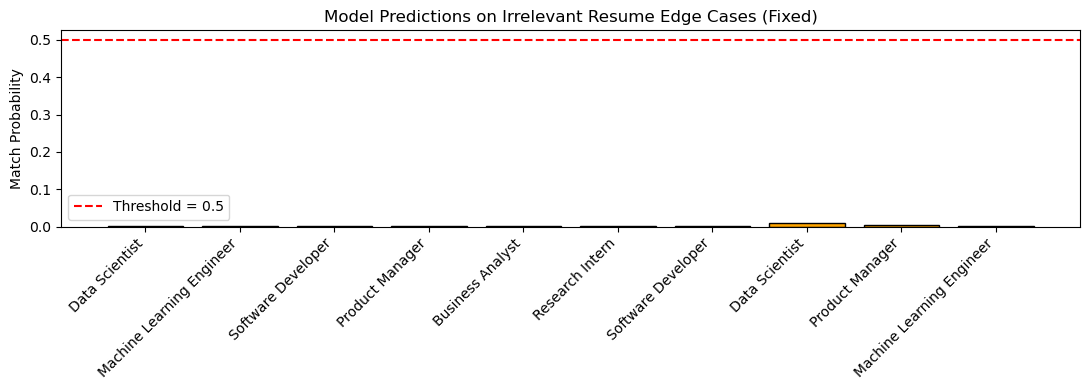

 Saved plot: irrelevant_resume_test_v2_fixed.png


In [6]:
plt.figure(figsize=(11, 4))
plt.bar(range(len(pred_probs)), pred_probs, color="orange", edgecolor="black")
plt.xticks(range(len(pred_probs)), roles, rotation=45, ha="right")
plt.ylabel("Match Probability")
plt.title("Model Predictions on Irrelevant Resume Edge Cases (Fixed)")
plt.axhline(0.5, color="red", linestyle="--", label="Threshold = 0.5")
plt.legend()
plt.tight_layout()
plt.savefig("irrelevant_resume_test_v2_fixed.png")
plt.show()

print(" Saved plot: irrelevant_resume_test_v2_fixed.png")